<h1><center>CS5242 Project</center></h1>

## Problem statement

The integration of machine learning and vehicular perception enables various active safety measures in autonomous driving. However, numerous issues in a dynamic urban environment, such as suboptimal weather conditions, performance of objection detection, perception and decision making accuracy in autonomous driving, makes it dangerous and costly to collect data from the real world. Therefore, we wish to investigate the feasibility of training vehicle detection via the use of image data generated from video games.

## Data collection

In this work, we aim to collect a traffic image dataset from a 2013 open world video game “Grand Theft Auto V” (GTA V). GTA V has detailed and diverse game scenes, as it’s open world was modelled after the city of Los Angeles. Image dataset can be obtained by recording a gameplay video and converting it into image sequences. 
In detail, we recording a player's playing status of GTA into a video file. Then use convert the video file into image sequences using the code below:

In [ ]:
# Convert video into image sequence
import os
import cv2
import numpy as np
from glob import glob
from random import shuffle

path = 'D:/Github/CS5242_Project/output/'
dst = 'D:/Github/CS5242_Project/Test/'
files = glob(r"D:/Github/CS5242_Project/output\*.jpg")
vidcap = cv2.VideoCapture('Grand Theft Auto V_2021.10.13-00.00_01_1-1.m4v')

def video_to_img():
  success,image = vidcap.read()
  count = 0
  while success:
    cv2.imwrite(os.path.join(path, "%d.jpg" % count), image)   
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

def shuffle_img():
    num_images= len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    arange = np.arange(num_images)
    np.random.shuffle(arange)

    i = 0
    for file in files:
      print('file', str(file))
      os.rename(str(file), os.path.join(dst, str(arange[i] + 1) +'.jpg'))
      i = i+1

A glance of our collected dataset is as follows. It covers the various common traffic scenarios, such as vehicle paralleling, lane changing, pedestrain detection, traffic signal detection, car following, collision warning, etc..
In our experiments, we record a 4:52 minutes video data, then convert the video sequence into 8742 images.
Our collected dataset is available here: (https://drive.google.com/drive/folders/1VC1MVYZWxWdbyIPAjdu7vfWq-vLzg06k?usp=sharing)
#### TODO: More explanation on dataset (motivation - eg. For traffic monitoring )

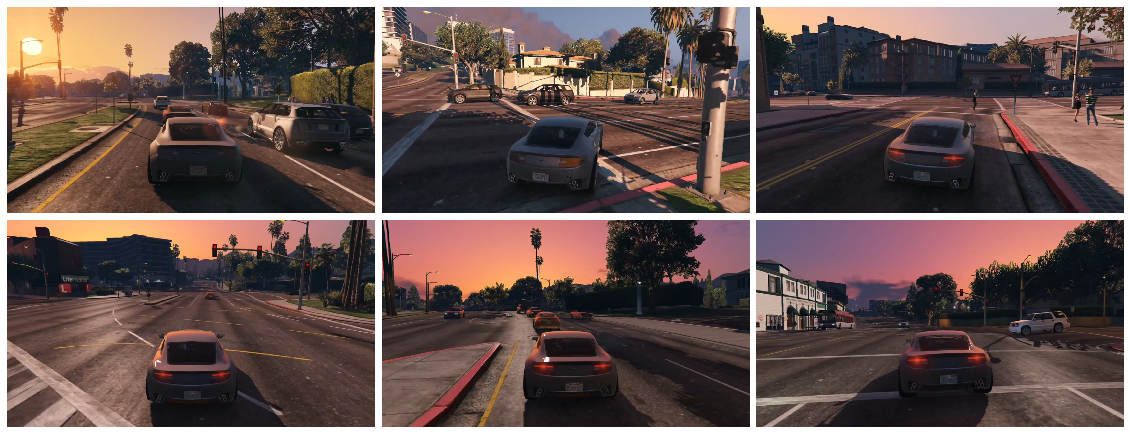

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20, 9))
  
# reading images
Image1 = plt.imread('1.png')
Image2 = plt.imread('2.png')
Image3 = plt.imread('3.png')
Image4 = plt.imread('4.png')
Image5 = plt.imread('5.png')
Image6 = plt.imread('6.png')

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [Image1, Image2, Image3, Image4, Image5, Image6]):
    ax.imshow(im)
    ax.axis('off')
    
plt.show()

## Image Annotation
To perform supervised learning for vehicle detection, we shall label the data using bounding box annotation, which defines the location of the target vehicle by rectangular boxes.
Inspired by the high-performance of YOLO [1] network in the object detection task, so we feed our collected image datasets into a pre-trained YOLO network (link). The returning results are served as labels. Then we do manually fine tune.

#### TODO: More explanations on YOLO labeling (eg. brief steps)

In [ ]:
## Explain steps for labelling (if necessary)

## Image augmentation

It is essential to incorporate data augmentations to create more variability in available data. The following list provides the types of image augmentations performed.

- Blur (Gaussian, Average, Median)
- Brightness variation with per-channel probability
- Adding Gaussian Noise with per-channel probability
- Random dropout of pixels
- Examples of image blur, brightness/ color jitter and Dropout are shown below. 

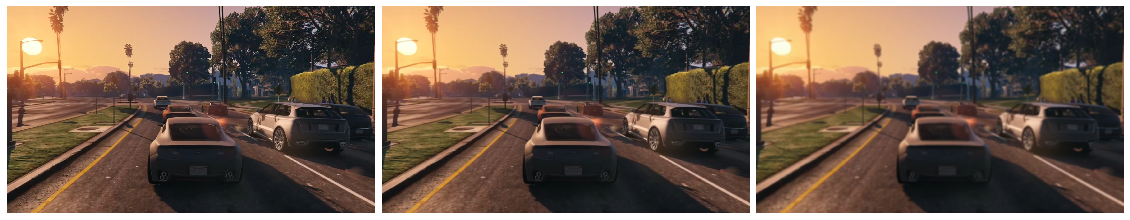

In [26]:
# Augmentation by Gaussian blur
import cv2
import numpy
import matplotlib.pyplot as plt
src = cv2.imread('1.png', cv2.IMREAD_UNCHANGED)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
# apply guassian blur on src image
dst_5 = cv2.GaussianBlur(src,(5, 5), cv2.BORDER_DEFAULT)
dst_15 = cv2.GaussianBlur(src,(15, 15), cv2.BORDER_DEFAULT)

fig = plt.figure(figsize=(20, 9))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 3),  
                 axes_pad=0.1)

for ax, im in zip(grid, [src, dst_5, dst_15]):
    ax.imshow(im)
    ax.axis('off')
    
plt.show()

In [ ]:
## TODO:
"""
- Brightness variation with per-channel probability
- Adding Gaussian Noise with per-channel probability
- Random dropout of pixels
"""

## Generate Region proposal
- What is region proposal
- How it can be used for object detection
- How to generate region proposal


In [7]:
import cv2
from pdb import set_trace as bp

def propose_regions(img, num_regions=3):
    """
    Implementation of selective search for region proposal.
    We use SelectivSearchFast because we try not to bottleneck downstream neural network.
    :param img: Input image.
    :param num_regions: Number of top regions to return. Default is 200.
    """
    segmentor = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    segmentor.setBaseImage(img)
    segmentor.switchToSelectiveSearchFast()
    regions = segmentor.process()

    # Filter regions that are too small
    width, height, _ = img.shape
    filter = []
    for _, _, region_width, region_height in regions:
        filter.append((float(region_width)/width >= 0.1 or float(region_height)/height >= 0.1))

    regions = regions[filter]

    return regions[:num_regions]

def visualize_regions(img, regions):
    """
    Visualize region proposals on an img.
    :param img: Input image.
    :param regions: Region proposals output from propose_regions function.
    """
    # Don't draw on original image
    img_copy = img.copy()
    for x, y, width, height in regions:
        cv2.rectangle(img_copy, (x, y), (x + width, y + height), (0, 250, 250), 3, cv2.LINE_AA)

    return img_copy


In [8]:
img = cv2.imread("1.png")
regions = propose_regions(img)
print('regions', regions)

regions [[853 613 165  86]
 [841 178 176 190]
 [954 798 270 103]]


In [9]:
proposal_img = visualize_regions(img, regions)

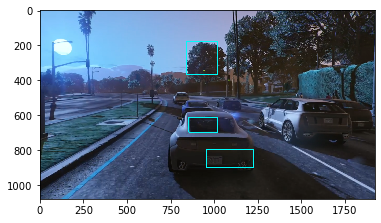

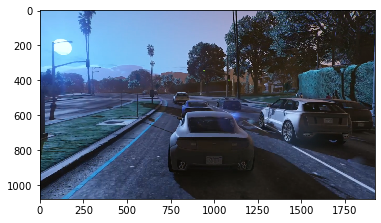

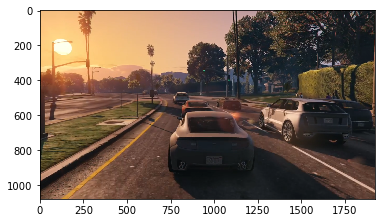

In [12]:
import matplotlib.pyplot as plt
plt.imshow(proposal_img)
plt.show()
plt.imshow(img)
plt.show()

## (Baseline) MLP
Due to the success of MLP on the simple and straight forward MNIST dataset, we choose MLP neural network as our baseline models for the object detection task. 
In detail, A multilayer perceptron (MLP) is a class of feedforward neural network. Except for the input nodes, each node is a neuron that uses a nonlinear activation function, which allows to distinguish data that is not linearly separable. 
The network structure of our MLP network is as follows:

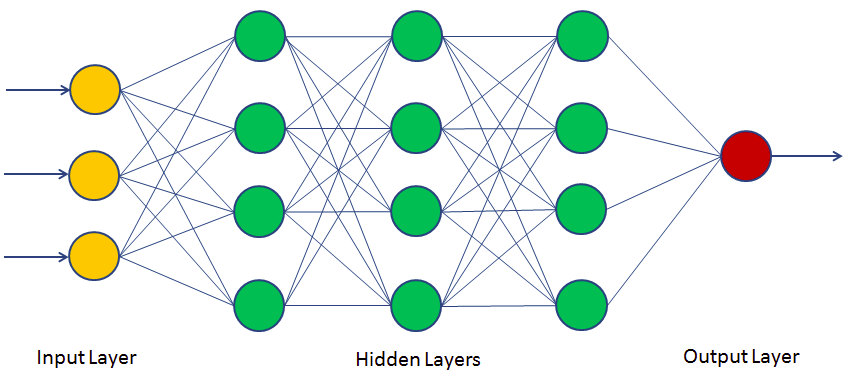

In [1]:
from IPython.display import Image
Image(filename='mlp.png') 
## Note: Image source: https://www.pinterest.com/pin/540713499009847029/
## To draw a similar figure like the one shown below

In [ ]:
### MLP code here

## Performance evaluation- mAP- MLP

## MLP results & Analysis

The performance of MLP lags behind CNN and is deemed insufficient for the object detection task (why).
One disadvantage is that it includes too many parameter. The number of parameters = width x depth x height. Each node is connected to another in a very dense web — resulting in redundancy and inefficiency.
Another adavantage is that MLP takes flattened vectors as input and it disregards the spacial information. 

## RCNN neural network
- General idea;
- Explain the network structure
The network architecture is shown in Figure below;

#### TODO: Explain Motivation, description, equation

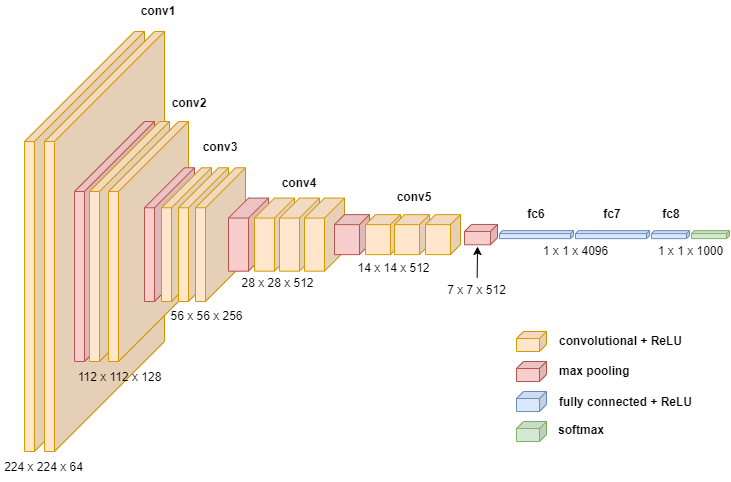

In [1]:
from IPython.display import Image
Image(filename='sample_model.png') 
## Note: Image source: https://towardsdatascience.com/how-to-easily-draw-neural-network-architecture-diagrams-a6b6138ed875
## To draw a similar figure like the one shown below

In [ ]:
## RCNN code - Implementation

## Performance evaluation- mAP

## RCNN- Results

Show loss degrade/ results

## Summary between MLP and RCNN
- Implement MLP and RCNN on our GTA dataset;
- MLP as baseline, RCNN are expected to improve MLP. 

| Model      	| Number of layers  	| Average Precision   |  mAP               	| Running time  |   Device (cpu/gpu)  |
|-----------	|-------------------	|-------------------- |---------------------|---------------|-------------------	|
| MLP         |                     |                     |                     |               |                     |
| RCNN        |                     |                     |                     |               |                     |

## RNN / ANN here

## Performance Analysis
- Explain the overall performance;
- Why model A is the best?
- Why model B is the worst?
- Compare running time, pros and cons of each model.
- What is the effect of the number of layers to the accuracy of object detection?
- Explain the loss againest iterations;
- Overfitting or Underfitting?
- Future insights 
  - Accurate object detection relies on big data to avoid overfitting, while we have only a limited dataset. To handle this issue, we shall implement several data augmentation algorithms: a data-space solution to the problem of limited data.
  - Most object detection models were trained from relatively ideal scenarios, such as sunny days. Therefore, we will also need to quantify how our model performs under various bad weather conditions: heavy rain, snowy, foggy.

## Agnostic learning 
Perform agnostic study, eg. adding rain drops onto the original dataset; Evaluate its impact on performance.